In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
df = pd.read_csv('data/clean_nonull.csv')

df = pd.concat([
    df.drop(columns=['VKORC1_SNP', 'CYP2C9 consensus']),
    pd.get_dummies(df['VKORC1_SNP'], prefix='VKORC1_SNP', drop_first=True),
    pd.get_dummies(df['CYP2C9 consensus'], prefix='CYP2C9', drop_first=True)
], axis=1)

df['constant'] = 1

df['label'] = df['correct_dosage'].map({'low': 0, 'medium': 1, 'high': 2})

In [3]:
def clinical_baseline(x):
    x = np.squeeze(x)
    
    sqrt_weekly_dose = 4.0376 - 0.2546 * x[0] + 0.0118 * x[1] \
    + 0.0134 * x[2] - 0.6752 * x[3] \
    + 0.4060 * x[4] + 0.0443 * x[5] \
    + 1.2799 * x[6] - 0.5695 * x[7]
    
    
    cutoffs = np.array([0, np.sqrt(21), np.sqrt(49)])
    
    return np.where(cutoffs < sqrt_weekly_dose)[0].max()


# choose the closest integer
def find_closest(x):
    if x < 0.5:  # closer to 0 than 1 or 2
        return 0
    elif x < 1.5: # closer to 1 than 0 or 2
        return 1
    return 2

In [38]:
np.linspace(0.8, 0.01, X.shape[0]-1)

array([0.8      , 0.7998198, 0.7996396, ..., 0.0103604, 0.0101802,
       0.01     ])

In [42]:
np.random.seed(1)

S = 20

perfs = []
for s in tqdm(range(S)):
    order = np.random.choice(range(df.shape[0]), size=df.shape[0], replace=False)
    X = df.drop(columns=['correct_dosage', 'label']).iloc[order, :].values
    y = df['label'].values[order]

    # randomly sample the first arm, and set the corresponding reward
    chosen_arms = [np.random.randint(3)]

    # set up the b vectors
    b = {
        0: np.zeros(X.shape[1]).reshape(X.shape[1], 1),
        1: np.zeros(X.shape[1]).reshape(X.shape[1], 1),
        2: np.zeros(X.shape[1]).reshape(X.shape[1], 1)
    }

    # set up the A matrices
    A = {
        0: np.identity(X.shape[1]),
        1: np.identity(X.shape[1]),
        2: np.identity(X.shape[1])
    }

    alpha = 0.8
    
    for i in range(1, X.shape[0]):  # choose a patient
        x_t = X[i].copy().reshape(X.shape[1], 1).copy()
        epsilon = alpha / i  # eps is the probability that you choose a random arm

        theta = []
        p = []
        for a in range(3):
            A_inv = np.linalg.inv(A[a])
            p.append(x_t.T @ A_inv @ b[a])

        pred_a = int(np.argmax(p)) if np.random.uniform() > epsilon else np.random.randint(3)

        r_t = 0 if y[i] == pred_a else -1

        # update the matrices
        A[pred_a] += x_t @ x_t.T
        b[pred_a] += r_t * x_t
        
        chosen_arms.append(pred_a)    
        
    perf = pd.DataFrame({
        "run": s,
        "predicted_arm": chosen_arms,
        "true_arm": y,
        "clincal_baseline_predicted_arm": [clinical_baseline(x) for x in X]
    })

    perf['cumulative_accuracy'] = (
        perf['predicted_arm'] == perf['true_arm']
    ).cumsum() / (perf.index + 1)

    perf['cumulative_fixed_baseline_accuracy'] = (
        perf['true_arm'] == 1
    ).cumsum() / (perf.index + 1)
    
    perf['cumulative_clinical_baseline_accuracy'] = (
        perf['clincal_baseline_predicted_arm'] == perf['true_arm']
    ).cumsum() / (perf.index + 1)

    perf['cumulative_regret'] = -1 * np.where(
        perf['predicted_arm'] == perf['true_arm'],
        0,
        -1
    ).cumsum()
    
    perf['cumulative_fixed_baseline_regret'] = -1 * np.where(
        perf['true_arm'] == 1,
        0,
        -1
    ).cumsum()
    
    perf['cumulative_clinical_baseline_regret'] = -1 * np.where(
        perf['clincal_baseline_predicted_arm'] == perf['true_arm'],
        0,
        -1
    ).cumsum()
    
    perfs.append(perf)

egreedy = pd.concat(perfs)
egreedy['t'] = egreedy.index

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:04<00:00,  3.23s/it]


<AxesSubplot:xlabel='t'>

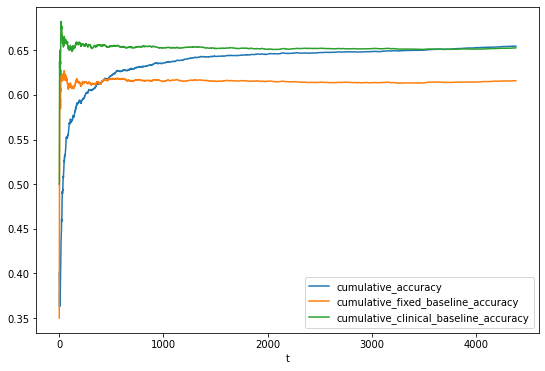

In [43]:
egreedy_grouped = egreedy.groupby('t')[[
    'cumulative_accuracy', 'cumulative_fixed_baseline_accuracy', 'cumulative_clinical_baseline_accuracy',
    'cumulative_regret', 'cumulative_fixed_baseline_regret', 'cumulative_clinical_baseline_regret'
]].mean()    

egreedy_grouped[[
    'cumulative_accuracy',
    'cumulative_fixed_baseline_accuracy',
    'cumulative_clinical_baseline_accuracy',
]].plot(figsize=(9,6))

<AxesSubplot:xlabel='t'>

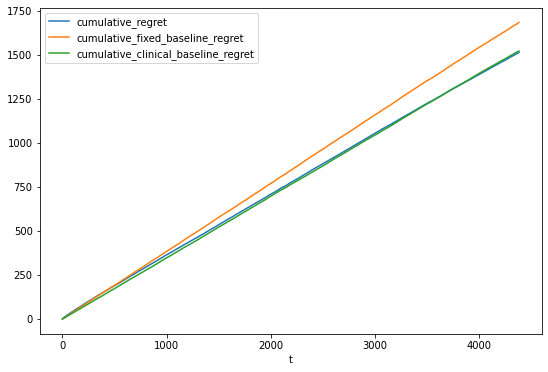

In [32]:
egreedy_grouped[[
    'cumulative_regret',
    'cumulative_fixed_baseline_regret',
    'cumulative_clinical_baseline_regret',
]].plot(figsize=(9,6))

In [36]:
egreedy_grouped.reset_index().to_csv('egreedy_results.csv', index=False)

In [37]:
egreedy_grouped_std = egreedy.groupby('t')[[
    'cumulative_accuracy', 'cumulative_fixed_baseline_accuracy', 'cumulative_clinical_baseline_accuracy',
    'cumulative_regret', 'cumulative_fixed_baseline_regret', 'cumulative_clinical_baseline_regret'
]].std() 

egreedy_grouped_std.reset_index().to_csv('egreedy_results_std.csv', index=False)